In [72]:
import retro
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import time
import scipy.misc
from multiprocessing.pool import ThreadPool

env = None

In [119]:
if env is None:
    env = retro.make(game='SonicTheHedgehog2-Genesis', state='EmeraldHillZone.Act1')
_ = env.reset()

frame, reward, done, info = env.step( env.action_space.sample() )

/home/mike/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


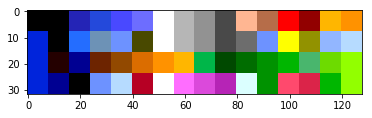

In [120]:
palate_image = scipy.misc.imread( 'data/sonic2/palate.png', mode='RGBA' )
plt.imshow( palate_image )

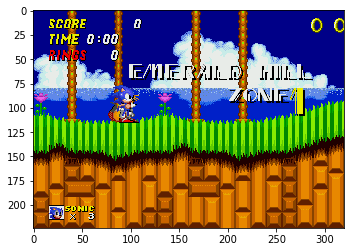

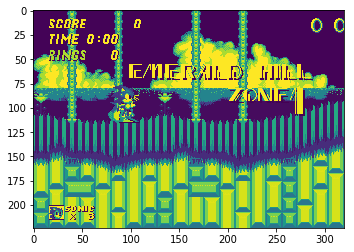

In [122]:
def imageTo8BitColor( image ):
    assert image.shape[ -1 ] == 3 or image.shape[ -1 ] == 4
    
    output_image = np.zeros( image.shape[ 0 : 2 ], dtype=np.uint8 )

    output_image[ :, : ]  = ( image[ :, :, 0 ] / 32 ).astype( np.uint8 ) * 32 # << 4
    output_image[ :, : ] += ( image[ :, :, 1 ] / 32 ).astype( np.uint8 ) * 4  # << 2 
    output_image[ :, : ] += ( image[ :, :, 2 ] / 64 ).astype( np.uint8 )
    
    return output_image

plt.imshow( frame )
plt.subplots()
plt.imshow( imageTo8BitColor( frame ) )

(71680,)


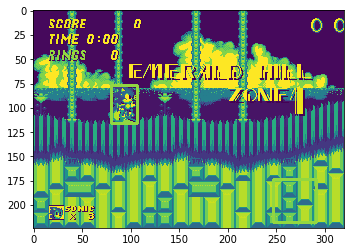

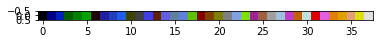

In [117]:
frame = ( frame / 32 ).astype( np.uint8 ) * 32

flat_frame = frame.copy()

palate, flat_frame = np.unique( flat_frame.reshape( -1, flat_frame.shape[ 2 ] ), axis=0, return_inverse=True )

print( flat_frame.shape )

flat_frame = flat_frame.reshape( frame.shape[ :2 ] ).astype( np.uint8 )

plt.imshow( flat_frame )
plt.subplots()
plt.imshow( palate[None] )

/home/mike/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True False ...  True  True  True]
 ...
 [ True  True  True ... False  True  True]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


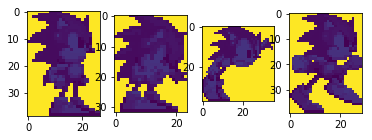

In [58]:
sonics = []
sonics_raw = []
sonic_dir = 'data/sonic2/sonic'
sonic_files = os.listdir( sonic_dir )
sonic_files.sort()
for file_i, file in enumerate( sonic_files ):
    sonic_dir_file = os.path.join( sonic_dir, file )
    
    sonic = scipy.misc.imread( sonic_dir_file, mode='RGBA' )
    sonic_raw = sonic.copy()

    sonic_flat = sonic.reshape( -1, sonic.shape[ 2 ] )
    sonic_palatized = np.full( sonic_flat.shape[ 0 ], 255 )

    lost_pixels = False
    for i, pixel in enumerate( sonic_flat ):
        if( pixel[ 3 ] == 0 ):
            pallate_pixel = 255
        else:
            pallate_pixel = np.argwhere( np.all( palate == pixel[ 0 : 3 ], axis=1 ) )
            if( len( pallate_pixel ) == 0 or len( pallate_pixel[ 0 ] ) == 0 ):
                lost_pixels = True
                break
            sonic_palatized[ i ] = pallate_pixel

    sonic_palatized = sonic_palatized.reshape( sonic.shape[ 0 : 2 ] ).astype( np.uint8 )

    if not lost_pixels:
        sonics_raw.append( sonic_raw )
        sonics.append( sonic_palatized )

mask = sonics[0][:, :] == 255
print( mask )
    
plt.subplot( 1, 4, 1 )
plt.imshow( sonics[ 0 ] )
plt.subplot( 1, 4, 2 )
plt.imshow( sonics[ 1 ] )
plt.subplot( 1, 4, 3 )
plt.imshow( sonics[ 2 ] )
plt.subplot( 1, 4, 4 )
plt.imshow( sonics[ 26 ] )

1.5716389999999762
(array([ 3.,  3., 16., 30., 30., 43., 48., 36., 26., 12.]), array([0.67673171, 0.6949803 , 0.71322889, 0.73147749, 0.74972608,
       0.76797467, 0.78622327, 0.80447186, 0.82272046, 0.84096905,
       0.85921764]), <a list of 10 Patch objects>)
(array([107., 130.,   1.,   1.,   4.,   3.,   0.,   0.,   0.,   1.]), array([0.006196, 0.006326, 0.006456, 0.006586, 0.006716, 0.006846,
       0.006976, 0.007106, 0.007236, 0.007366, 0.007496]), <a list of 10 Patch objects>)
(224, 320, 3)


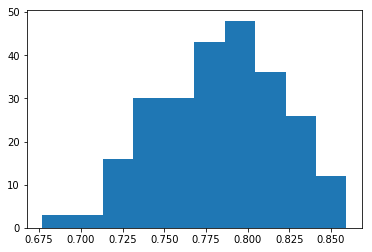

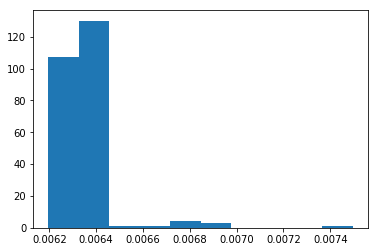

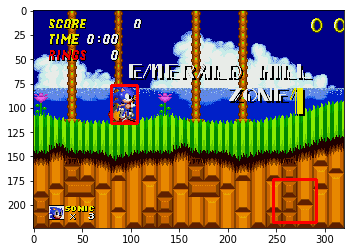

In [75]:
def findInFrame( template, frame ):
    start_time = time.clock()
    w, h = template.shape[ 0:2 ]

    mask = np.full( template.shape[ 0 : 2 ], 255 )
    mask[ template[ :, : ] == 255 ] = 0

    results = cv.matchTemplate( frame, template, cv.TM_CCORR_NORMED )

    _, score, _, max_loc = cv.minMaxLoc( results )

    return score, ( max_loc[ 0 ], max_loc[ 1 ] ), ( max_loc[ 0 ] + h, max_loc[ 1 ] + w  ), time.clock() - start_time

def findInFrame_thread( input_info ):
    template, frame = input_info
    return findInFrame( template, frame )

all_sprite_results = []

start_time = time.clock()

for sonic in sonics:
    results = findInFrame( sonic, flat_frame )
    all_sprite_results.append( results )

print( time.clock() - start_time )

scores = [ sprite_results[ 0 ] for sprite_results in all_sprite_results ]
times = [ sprite_results[ 3 ] for sprite_results in all_sprite_results ]

highest_score = np.max( scores )
highest_score_idx = np.argmax( scores )

print( plt.hist( scores ) )
plt.subplots()
print( plt.hist( times ) )
plt.subplots()

score, tl, br, runtime = all_sprite_results[ highest_score_idx ]

cv.rectangle( frame, tl, br, 255, 2 )
plt.imshow( frame )
print( frame.shape )

0.9999998807907104 0


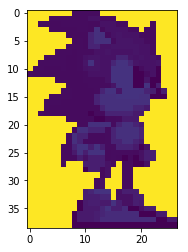

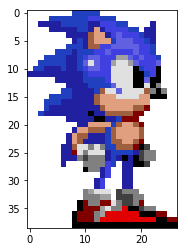

In [62]:
plt.imshow( sonics[ highest_score_idx ] )
plt.subplots()
plt.imshow( sonics_raw[ highest_score_idx ] )
print( highest_score, highest_score_idx )